# Factors of Academic Success: Analysis Project
(enter short description here)

## Importing libraries and survey spreadsheets

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### - Read survey spreadsheets

In [2]:
filepath = "C:/Users/Dennis/Documents/Git/Factors of Academic Success/Survey Spreadsheets/"
survey101 = pd.read_excel(filepath + "Factors of Academic Success Survey (1.01).xlsx")

#### - Merge datasets together

In [3]:
#surveydata = pd.merge(left=survey101, right=othersurvey, how="left") or maybe concat, idk lol
surveydata = survey101.copy()
#surveydata.columns = surveydata.columns.str.lower
#map(str.lower, surveydata.columns)
surveydata.columns = map(str.lower, surveydata.columns)

## Basic data cleaning and transformation

#### - Convert list cells to lists

In [4]:
for column in ['self_improv', 'activities', 'watched_media', 'chosen_music_artists']:
    surveydata[column] = surveydata[column].str.split(",")

#### - Calculate the average amount of sleep for each person

In [5]:
def time_to_datetime(column, dataf=surveydata):
    time_day = []
    time_time = []
    time_dt = []
    # Insert Date
    for i in range(dataf.shape[0]):
        if column == 'up_from_bed' or (column == 'go_to_bed' and dataf[column][i].hour < 5): 
            time_day.append("2000/01/02 ") # Special for timedelta where one column can have more than one possible day
        else:
            time_day.append("2000/01/01 ")
        
    # Insert Time        
    for time in list(dataf[column]):
        time_time.append(str(time))
    
    # Concat date and time and convert to datetime object
    for date_time in list(pd.Series(time_day) + pd.Series(time_time)):
        time_dt.append(dt.datetime.strptime(date_time, "%Y/%m/%d %H:%M:%S"))
    
    return pd.Series(time_dt)
    
surveydata.insert(24, 'avg_sleep_hours', time_to_datetime('up_from_bed') - time_to_datetime('go_to_bed'))

def clean_avg_sleep(hours_of_sleep):
    if hours_of_sleep > 15:
        return hours_of_sleep - 12
    else:
        return hours_of_sleep
    
surveydata.avg_sleep_hours = surveydata.avg_sleep_hours.apply(lambda x: x.seconds / 3600).apply(clean_avg_sleep)

#### - Map all music-related majors to be called "Music"

In [6]:
surveydata.loc[surveydata.major.str.contains(r"music", case=False, na=False, regex=True), 'major'] = "Music"

#### - Compare SAT and ACT scores and keep the highest one as a converted SAT score

In [7]:
act_sat = {'36':1590, '35':1540, '34':1500, '33':1460, '32':1430, '31':1400, '30':1370, '29':1340, '28':1310, '27':1280, '26':1240, '25':1210, '24':1180, '23':1140, '22':1110, '21':1080, '20':1040, '19':1010, '18':970}
def act_to_sat(act):
    if np.isnan(act):
        return np.NaN
    else:
        score = str(int(act))
        if score in act_sat:
            return act_sat[score]
        else:
            return np.NaN
        
surveydata.insert(11, 'converted_sat', surveydata.act.apply(act_to_sat))
select_rows = (surveydata.sat.fillna(0) > surveydata.converted_sat.fillna(0))
surveydata.loc[select_rows, 'converted_sat'] = surveydata.loc[select_rows, 'sat']
surveydata.converted_sat = surveydata.converted_sat.astype(int)

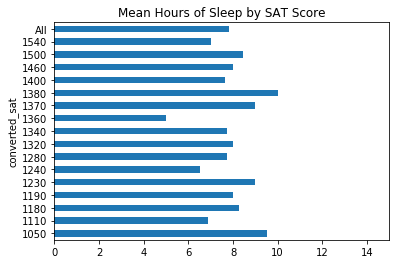

In [20]:
pv_scores = surveydata.pivot_table(values='avg_sleep_hours', index='converted_sat', aggfunc=np.mean, margins=True)
pv_scores.plot(kind='barh', xlim=(0,15), title='Mean Hours of Sleep by SAT Score', legend=False)

<function matplotlib.pyplot.show(*args, **kw)>

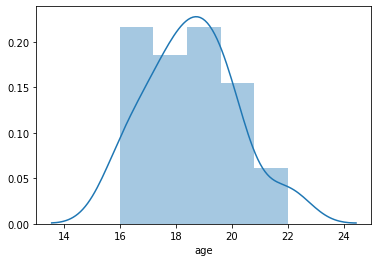

In [17]:
sns.distplot(surveydata['age'])
plt.show